In [ ]:
!pip install PyPDF4

In [2]:
#python 2.7 3.6 compatibility
try:
    input = raw_input
except NameError:
    pass

The aim of this work is to provide a tool for digitizign charts from thermohygrographs. Thermohygrographs have been used in the last centuries and are still one of the most widly used instrument for monitoring the temperature and relative humidty values inside museums and collections of delicates Cultural Heritage objects. The information collected during the years, is important for understanding the influence of the conditions on the objects and get insights on the combined action of climate change and actions taken to control the environmental condition inside the bulding. However, there are currently a lack of tools for digitizing the mthermohygrogrphs charts collected, and retrieving data data can be later analyzed using modern data-analysis techniques. 
There are some works related Digitizing of Analogue Data-Charts from
Thermohygrographs https://it.p.lodz.pl/file.php/12/2017-1/jacs-1-2017-radon.pdf
Here, we present the digitalization of the data collected using the thermohygrograph Almoiraghi Mod. 1750/C. This hermohygrographs collectes the data in sheet with dimension(xxxx, xxxx) on the left pad of the sheet the user writes the location and the date where the data is located. The sheet consists of two plots on the plot on the top we have the temperature in a range between -35 to 45 °C. The plot on the bottom records the relative humidity (RH) in a range from 0 to 100%. 
The temperature plot is subdivided in 17 quadrands the distance between the major ticks is constant
The RH plot is subdivided with 10 major ticks, each representing increasing of 10% of RH.In this case, because the response of the hygrometer is not linear, the distance between the ticks vary. 
These kind of hygrometers can usually measure with two velocity, the charts has hence a double x scale one can record a week the other during a day.

In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime,timedelta 
from scipy.interpolate import interp1d

In [4]:
path = r'/home/opdate/Projects/fogliodiagrammale/doc01377820200113132615.pdf'

## Solution using PyPDF4

In [3]:
import PyPDF4
from io import BytesIO
from PIL import Image
import cv2
images = []
with open(path,'rb') as pdf:
    # https://stackoverflow.com/a/34116472/2132157
    input1 = PyPDF4.PdfFileReader(pdf)
    page0 = input1.getPage(0)
    xObject = page0['/Resources']['/XObject'].getObject()
    for obj in xObject:
        if xObject[obj]['/Subtype'] == '/Image':
            size = (xObject[obj]['/Width'], xObject[obj]['/Height'])
            data = xObject[obj].getData()
            if xObject[obj]['/ColorSpace'] == '/DeviceRGB':
                mode = "RGB"
            else:
                mode = "P"

            if xObject[obj]['/Filter'] == '/FlateDecode':
                img = Image.frombytes(mode, size, data)
                images.append(img)
            elif xObject[obj]['/Filter'] == '/DCTDecode':
                nparr = np.fromstring(data, np.uint8)
                img= cv2.imdecode(nparr, cv2.IMREAD_COLOR)
                images.append(img)
            elif xObject[obj]['/Filter'] == '/JPXDecode':
                img = Image.open(mode, size, data,decoder_name='PNG')
                images.append(img)

NameError: name 'np' is not defined

In [7]:
%qtconsole

In [ ]:
plt.imshow(np.rot90(images[0],1))

The solution usion opencv and PyPDF4 seems returning some decoding errors.
# Solution using pdf2image

In [5]:
from pdf2image import convert_from_path
images_p2i = convert_from_path(path)

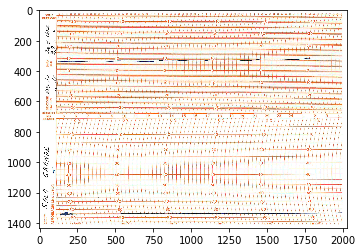

In [6]:
plt.imshow(images_p2i[3])

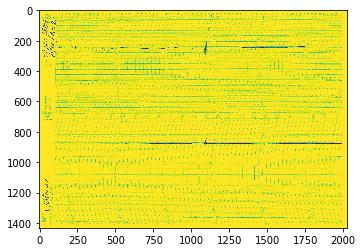

In [47]:
plt.imshow(np.array(images_p2i[0])[:,:,0])

In [48]:
img = np.array(images_p2i[3])

In [49]:
%matplotlib
from itertools import cycle
titles = ['RH_plot','location','datem','temperature_plot','Close the plot']
newarray = img
c = [0]
from matplotlib.widgets import RectangleSelector
label = titles[0]
fig, current_ax = plt.subplots()
current_ax.imshow(newarray)
current_ax.set_title("Drag a ROI over %s" %titles[c[0]])

def line_select_callback(eclick, erelease):
    
    'eclick and erelease are the press and release events'
    x1, y1 = int(eclick.xdata), int(eclick.ydata)
    x2, y2 = int(erelease.xdata), int(erelease.ydata)  
    print("%s = img[%s:%s,%s:%s]"% (titles[c[0]], y1, y2, x1, x2))
    c[0]+=1
    current_ax.set_title("Drag a ROI over %s" %titles[c[0]])  
    fig.canvas.draw()
    fig.canvas.flush_events()
    
    
    
    


def toggle_selector(event):
    print(' Key pressed.')
    if event.key in ['Q', 'q'] and toggle_selector.RS.active:
        print(' RectangleSelector deactivated.')
        toggle_selector.RS.set_active(False)
    if event.key in ['A', 'a'] and not toggle_selector.RS.active:
        print(' RectangleSelector activated.')
        toggle_selector.RS.set_active(True)

print("\n      click  -->  release")

# drawtype is 'box' or 'line' or 'none'
toggle_selector.RS = RectangleSelector(current_ax, line_select_callback,
                                       drawtype='box', useblit=True,
                                       # don't use middle button
                                       button=[1, 3],
                                       minspanx=5, minspany=5,
                                       spancoords='pixels',)
plt.connect('key_press_event', toggle_selector)

plt.show()


Using matplotlib backend: TkAgg

      click  -->  release
RH_plot = img[710:1428,117:1999]


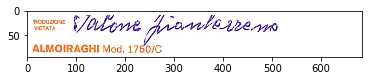

In [90]:
%matplotlib inline
location = img[739:1422,9:103]
plt.imshow(np.rot90(location,-1))

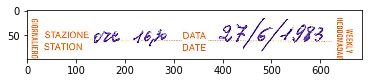

In [91]:
datem = img[9:694,4:103]
plt.imshow(np.rot90(datem,-1))


In [111]:
temperature_plot = img[9:681,110:1990]
plt.imshow(temperature_plot)


In [50]:
RH_plot = img[691:1404,108:1988]
plt.imshow(RH_plot)

In [141]:
plt.imshow(RH_plot)
plt.imshow(RH_plot[:,:,0])

In [52]:
RH_plot = img[705:1399,116:1991]
location = img[721:1385,3:102]
datem = img[8:716,3:121]
temperature_plot = img[22:680,113:1988]


To identify the values we take advantege that the blu ink absorbs in the red channel, hence we retrive the index of the lower value in each column of the red channel.

In [53]:
minarr = np.argmin(RH_plot[:,:,0],axis=0)
xr = np.arange(len(minarr))
minarrT = np.argmin(temperature_plot[:,:,0],axis=0)
xT = np.arange(len(minarrT))

In [54]:
%matplotlib
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(RH_plot)
ax.scatter(xr,minarr)

Using matplotlib backend: TkAgg


We see that some outliers are detected. For removing the outliers different approces are possible (see appendix 1), In this case we filter values that are outside one standard deviation.

In [55]:
from scipy import interpolate
from scipy.ndimage.morphology import binary_closing

#from scipy.interpolate import UnivariateSpline
def sigmafilter(minarr,interpolation=False,closing=True):
    xr = np.arange(len(minarr))
    stdRH = np.std(minarr)
    meanRH = np.mean(minarr)
    lowerlim = meanRH - stdRH/2
    upperlim = meanRH + stdRH/2
    print(stdRH)
    maskedval = np.ma.masked_outside(minarr,lowerlim,upperlim)
    #spl = UnivariateSpline(xr[~maskedval.mask], minarr[~maskedval.mask],s=7,k=3)
    # We use a closing for removing small detection
    if closing:
        maskedval.mask = binary_closing(maskedval.mask)
        maskedval.mask[0] = True
        maskedval.mask[-1] = True
    
    if interpolation:
        xn = np.arange(min(xr[~maskedval.mask]), max(xr[~maskedval.mask]))
        f = interpolate.interp1d(xr[~maskedval.mask], minarr[~maskedval.mask],kind='cubic')
    else:
        xn = xr[~maskedval.mask]
        f = minarr[~maskedval.mask]
    return xn,f

In [56]:
%matplotlib
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(RH_plot)

ax.scatter(xr,minarr,color='b',alpha=0.2)
xn,res = sigmafilter(minarr,closing=True)
ax.scatter(xn,res,color='r',alpha=0.8)

Using matplotlib backend: TkAgg
22.4984236659


In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(temperature_plot)

ax.scatter(xT,minarrT,color='b',alpha=0.2)
xn,res = sigmafilter(minarrT,closing=True)
ax.scatter(xn,res,color='r',alpha=0.8)

23.9669875789


## Correcting the curve distortion

In [57]:
%matplotlib
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize


def correct_curvature(data,number_of_points,text='Select the 11 intersection at 0,10,20 .. 100 %RH'):
    def tellme(s):
        print(s)
        plt.title(s, fontsize=16)
        plt.draw()

    plt.clf()
    plt.imshow(data)
    plt.setp(plt.gca(), autoscale_on=False)

    tellme('When you are ready clik on the plot')

    plt.waitforbuttonpress()

    while True:
        pts = []
        while len(pts) < number_of_points:
            tellme(text)
            pts = np.asarray(plt.ginput(number_of_points, timeout=-1))
        # plot parabola, rotated with respect to the plot
        x = pts[:,1]
        y = pts[:,0]

        def parabola(x, a, b, c):
            return a*x**2 + b*x + c
        fit_params, pcov = scipy.optimize.curve_fit(parabola, x, y)
        x_fit = np.arange(math.ceil(min(x)),math.ceil(max(x))).astype(int)
        print(fit_params)
        y_fit = parabola(x_fit, *fit_params)
        plt.plot(y_fit, x_fit, label='fit')

        tellme('Click keyboard key for conferming, mouse for starting agian')

        if plt.waitforbuttonpress():
            break

    displacement = np.ceil(y_fit - min(y_fit)).astype(int)
    for ind,indx in enumerate(x_fit):
        #print(ind, indx)
        data[indx] = np.roll(data[indx],-displacement[ind],axis=0)
    plt.clf()
    plt.imshow(data)
    return data,pts

Using matplotlib backend: TkAgg


In [58]:
data_RH,pts_RH = correct_curvature(RH_plot,11)

When you are ready clik on the plot


/usr/local/lib/python2.7/dist-packages/matplotlib/backend_bases.py:2453: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)


Select the 11 intersection at 0,10,20 .. 100 %RH
[  3.90612138e-04  -2.78415730e-01   1.07179480e+03]
Click keyboard key for conferming, mouse for starting agian


In [23]:
data_T,pts_T = correct_curvature(temperature_plot,9)

When you are ready clik on the plot
Select the 11 intersection at 0,10,20 .. 100 %RH
[  3.80531835e-04  -2.71532437e-01   5.98391287e+02]
Click keyboard key for conferming, mouse for starting agian


## Linearity of the RH measurment
Because the RH measurment is not linear we have to build a model using the vaules that we manually select at various RH.

In [24]:
%qtconsole

In [104]:
x= pts_RH[:,1] # we extract the y coordinates of the values that we extracted will be the x of the next plot

In [105]:
RH_refvalues = range(0,101,10)

In [106]:
plt.scatter(x,RH_refvalues)
plt.xlabel("Pixel index")
plt.ylabel("True RH value")

In [107]:
from scipy.interpolate import interp1d, splrep
fRH = interp1d(x, RH_refvalues, kind='cubic')
xn = np.linspace(min(x),max(x),300)
plt.scatter(x,RH_refvalues)
plt.plot(xn,fRH(xn))
plt.xlabel("Pixel index")
plt.ylabel("True RH value")

In [36]:
from datetime import datetime,timedelta 
from scipy.interpolate import interp1d
import scipy.optimize
import math
from scipy.ndimage.morphology import binary_closing

In [16]:
from datetime import datetime,timedelta 
location = input("Write location: ")
instrument_model = input("Write instrument model: ")
begin_date = input ("Write begin date using spaces e.g. 1988 12 31 15 30 :")
begin_date = map(int,begin_date.split())
begin_datetime = datetime(*begin_date)
end_date = input ("Write end date using spaces e.g. 1988 12 31 15 30 or press enter to continue:")
if end_date != '':
    end_date = map(int,end_date.split())
    end_datetime = datetime(*end_date)

Write location: porta vescovo
Write instrument model: asdfa
Write begin date using spaces e.g. 1988 12 31 15 30 :1988 12 31 15 30
Write end date using spaces e.g. 1988 12 31 15 30 or press enter to continue:


Procedure pseudo-code:
- Extract the relevant region of the plot
- Determine the model and the date of acquisition
- Correct the distorstion of the measurment
- Find the position of the values
- Assign the correspective value to each pixel


#  Organizing the processing into classes
First we define a class representing the single diagram

In [205]:
img = np.array(images_p2i[10])
RH_plot = img[705:1399,116:1991]
location = img[721:1385,3:102]
datem = img[8:716,3:121]
temperature_plot = img[22:680,113:1988]

In [206]:
%matplotlib
class single_diagram:
    def __init__(self,data,majorticks,unit,cycle,begin_datetime):
        self.pixelhour = None
        self.time = None
        self.measured_values = None
        self.yfunc = None
        self.detected_points_y = None
        self.detected_points_x = None
        self.data = data
        self.unit = unit
        self.correction = 'Not performed'
        self.majorticks = majorticks
        self.cycle = cycle
        self.begin_datetime = begin_datetime
    
    def find_referencesystem(self):
        """correct curvature and return function for finding x and y values"""
        if self.correction == 'Performed':
            print('Correction already performed')
            return
        def tellme(s):
            print(s)
            plt.title(s, fontsize=16)
            plt.draw()
        a = self.majorticks[0]
        b = self.majorticks[1]
        c = self.majorticks[-1]
        text = "Select intersection at %s, %s ... %s %s" %(a,b,c,self.unit)
        plt.clf()
        plt.imshow(self.data)
        plt.setp(plt.gca(), autoscale_on=False)
        
        tellme('When you are ready clik on the plot')
        number_of_points = len(self.majorticks)
        plt.waitforbuttonpress()

        while True:
            pts = []
            while len(pts) < number_of_points:
                
                tellme(text)
                pts = np.asarray(plt.ginput(number_of_points, timeout=-1))
            # plot parabola, rotated with respect to the plot
            x = pts[:,1]
            y = pts[:,0]

            def parabola(x, a, b, c):
                return a*x**2 + b*x + c
            fit_params, pcov = scipy.optimize.curve_fit(parabola, x, y)
            x_fit = np.arange(math.ceil(min(x)),math.ceil(max(x))).astype(int)
            print(fit_params)
            y_fit = parabola(x_fit, *fit_params)
            plt.plot(y_fit, x_fit, label='fit')

            tellme('Click keyboard key for conferming, mouse for starting agian')

            if plt.waitforbuttonpress():
                break

        displacement = np.ceil(y_fit - min(y_fit)).astype(int)
        for ind,indx in enumerate(x_fit):
            #print(ind, indx)
            self.data[indx] = np.roll(self.data[indx],-displacement[ind],axis=0)
        plt.clf()
        plt.imshow(self.data)
        self.pts = pts
        # Curvature is corrected
        # We calculate the function for finding the y values
        f = interp1d(pts[:,1], self.majorticks, kind='cubic')
        self.yfunc = f
        # We calculate the dimension of pixel
        if measurement_cycle == 'w':
            self.pixelhour = 24.*7/self.data.shape[1]
        if measurement_cycle == 'd':
            self.pixelhour = 24./self.data.shape[1]
        self.correction = 'Performed'
    
    def auto_detectpoints(self):
        minarr = np.argmin(self.data[:,:,0],axis=0)
        xr = np.arange(len(minarr))
        plt.scatter(xr,minarr)
        self.detected_points_y = minarr
        self.detected_points_x =  xr
    
    def manual_detectpoints(self):
        """correct curvature and return function for finding x and y values"""
        def tellme(s):
            print(s)
            plt.title(s, fontsize=16)
            plt.draw()
        plt.clf()
        plt.imshow(self.data)
        plt.setp(plt.gca(), autoscale_on=False)
        
        tellme('Use left button to add and right to remove last point, prese ENTER to finish')
        plt.waitforbuttonpress()
        while True:
            pts = np.asarray(plt.ginput(-1, timeout=-1))
            if plt.waitforbuttonpress():
                break
        cyclelength = 0
        # in case we have multiple path we must add the previous elapsed time for each cycle
        for indx,val in enumerate(pts[1:,0]):
            # the x value is less then the previous we are begingin a new cycle
            if val < (pts[indx,0] - cyclelength):
                cyclelength += self.data.shape[1]
            pts[indx+1,0]+= cyclelength
        print('finish')           
        self.detected_points_y = pts[:,1]
        self.detected_points_x =  pts[:,0]
        
        
    #from scipy.interpolate import UnivariateSpline
    def sigmafilter(self,interpolation=False,closing=True):
        xr = np.arange(len(self.detected_points_x))
        stdRH = np.std(self.detected_points_y)
        meanRH = np.mean(self.detected_points_y)
        lowerlim = meanRH - stdRH/2
        upperlim = meanRH + stdRH/2
        print(stdRH)
        maskedval = np.ma.masked_outside(self.detected_points_y,lowerlim,upperlim)
        #spl = UnivariateSpline(xr[~maskedval.mask], minarr[~maskedval.mask],s=7,k=3)
        # We use a closing for removing small detection
        print(len(self.detected_points_y))
        print(len(maskedval))
        if closing:
            print("Closing")
            maskedval.mask = binary_closing(maskedval.mask)
            maskedval.mask[0] = True
            maskedval.mask[-1] = True
            

        if interpolation:
            print("Interpolation")
            xn = np.arange(min(xr[~maskedval.mask]), max(xr[~maskedval.mask]))
            f = interpolate.interp1d(xr[~maskedval.mask], self.detected_points_y[~maskedval.mask],kind='cubic')
            f = f(xn)
        else:
            xn = xr[~maskedval.mask]
            f = self.detected_points_y[~maskedval.mask]
        
        self.detected_points_y = f
        self.detected_points_x =  xn
    
    
    def calculate_values(self):
        t = [self.begin_datetime + timedelta(hours=i*self.pixelhour) for i in self.detected_points_x]
        self.time = t
        self.measured_values = self.yfunc(self.detected_points_y)
    
    def plot(self):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.time,self.measured_values)
        ax.set_ylabel(self.unit)

Using matplotlib backend: TkAgg


In [207]:
g = single_diagram(data=RH_plot,majorticks=range(0,101,10),unit="% RH",cycle='w',begin_datetime = begin_datetime)

In [208]:
g.find_referencesystem()

When you are ready clik on the plot
Select intersection at 0, 10 ... 100 % RH
[  3.87564170e-04  -2.85824195e-01   1.15106667e+03]
Click keyboard key for conferming, mouse for starting agian


In [209]:
g.manual_detectpoints()

Use left button to add and right to remove last point, prese ENTER to finish
finish


In [103]:
g.sigmafilter()

30.9998589749
1875
1875
Closing


In [210]:
g.calculate_values()

In [211]:
g.plot()
#len(g.measured_values)

In [106]:
plt.plot(g.measured_values)

Anothter alternative is to perfrom a semi automatic identification. This method is required when the measurment is collected for more then one cycle, and hence there are multiple lines on the plot. In this case, it's hareder for the algorithms to identify the path to follow. 
Sometimes ink stains and other artifacts might affect the measurment invalidating the process. 
A set of control points are identifyed by the user, the order in which the control points are selected following the acqusition of the measurment. A linear fitting is perform between each point. For each column of the plot, we identify the points where the ink of the pen is present, using for instance a threshold for selecting pixels with the clour close to the one of the ink. We set a distance threshold, it there aren't any detected points between the distance threshold, the interpolated value is used.
The coordinates of the closest points which is identifyed as ink is selected.  

In [73]:
img  = plt.imread('Complicated.tiff')
plt.imshow(img)

In [74]:
%matplotlib
plt.clf()
img = img[:,103:1992,:]
plt.imshow(img)
plt.setp(plt.gca(), autoscale_on=False)
plt.waitforbuttonpress()
while True:
    pts = np.asarray(plt.ginput(-1, timeout=-1))
    if plt.waitforbuttonpress():
        break
pts

Using matplotlib backend: TkAgg


array([[   23.20355634,  1127.34920426],
       [   32.45372467,  1187.4752984 ],
       [   48.64151925,  1268.41427129],
       [   83.32965049,  1303.10240252],
       [  113.39269756,  1316.97765502],
       [  143.45574463,  1330.85290751],
       [  180.45641795,  1337.79053376],
       [  205.89438085,  1335.47799168],
       [  226.70725959,  1328.54036543],
       [  261.39539083,  1323.91528126],
       [  303.02114831,  1330.85290751],
       [  349.27198996,  1330.85290751],
       [  390.89774744,  1326.22782335],
       [  411.71062619,  1337.79053376],
       [  437.14858909,  1342.41561792],
       [  474.14926241,  1340.10307584],
       [  511.14993573,  1347.04070209],
       [  541.2129828 ,  1349.35324417],
       [  585.15128237,  1347.04070209],
       [  631.40212401,  1344.72816   ],
       [  668.40279733,  1344.72816   ],
       [  682.27804983,  1342.41561792],
       [  689.21567607,  1335.47799168],
       [  703.09092857,  1326.22782335],
       [  735.46

In [75]:
%matplotlib
plt.imshow(img)
plt.plot(pts[:,0],pts[:,1])

Using matplotlib backend: TkAgg


In [76]:
column = 750
blue_threshold = 60
# find indexes of the pixels
indexes = np.argwhere(img[:,column,1] < blue_threshold)
print(indexes)

[[ 247]
 [ 248]
 [1318]
 [1319]]


In [77]:
plt.imshow(img)
plt.plot([column]*len(indexes),indexes,'x')

In [66]:
from scipy import interpolate
import math
f = interpolate.interp1d(pts[:,0],pts[:,1],kind='linear')
# this correspond to the columns
xran = np.arange(math.ceil(min(pts[:,0])),math.ceil(max(pts[:,0]))).astype(int)
ynew = f(xran)

In [67]:

distance_treshold = 10 # number of pixel the detected values can be from the control path
y_detected = []
for idx,column in enumerate(xran):
    indexes_detected = np.argwhere(img[:,column,1] < blue_threshold)
    # calculate the distances between the interpolated control point
    distances = np.abs(indexes_detected - ynew[idx])
    indx_close = np.argwhere(distances < distance_treshold)
    if len(indx_close) == 0:
        # No pixel are close to the control path
        # we keep the interpolated control point
        y_detected.append(ynew[idx])
    else:
        # Otherwise we keep the closest point to the interpolated value
        index_of_the_closest = np.argmin(distances)
        y_detected.append(indexes_detected[index_of_the_closest][0])
y_detected = np.array(y_detected)

In [68]:
plt.plot(xran,y_detected)
plt.imshow(img)

In [80]:
# check if x values are sorted
if not all(pts[i,0] <= pts[i+1,0] for i in range(len(pts[:,0])-1)):
    cyclelength = 0
    # in case we have multiple path we must add the previous elapsed time for each cycle
    for indx,val in enumerate(pts[1:,0]):
        # the x value is less then the previous we are begingin a new cycle
        if val < (pts[indx,0] - cyclelength):
            cyclelength += img.shape[1]
        pts[indx+1,0]+= cyclelength

f = interpolate.interp1d(pts[:,0],pts[:,1],kind='linear')
# this correspond to the columns
minx, maxx = math.ceil(min(pts[:,0])),math.ceil(max(pts[:,0]))
if maxx >= img.shape[1]:
    maxx = img.shape[1]
xran = np.arange(minx,maxx).astype(int)
ynew = f(xran)
        
distance_treshold = 10 # number of pixel the detected values can be from the control path
y_detected = []
for idx,column in enumerate(xran):
    indexes_detected = np.argwhere(img[:,column,1] < blue_threshold)
    # calculate the distances between the interpolated control point
    distances = np.abs(indexes_detected - ynew[idx])
    indx_close = np.argwhere(distances < distance_treshold)
    if len(indx_close) == 0:
        # No pixel are close to the control path
        # we keep the interpolated control point
        y_detected.append(ynew[idx])
    else:
        # Otherwise we keep the closest point to the interpolated value
        index_of_the_closest = np.argmin(distances)
        y_detected.append(indexes_detected[index_of_the_closest][0])
y_detected = np.array(y_detected)

In [81]:
plt.plot(xran,y_detected)
plt.imshow(img)

In [82]:
plt.plot(xran,y_detected)
plt.show()

# Tests

In [31]:
def generate_data(t, A, sigma, omega, noise=0, n_outliers=0, random_state=0):
    y = A * np.exp(-sigma * t) * np.sin(omega * t)
    rnd = np.random.RandomState(random_state)
    error = noise * rnd.randn(t.size)
    outliers = rnd.randint(0, t.size, n_outliers)
    error[outliers] *= 35
    return y + error

A = 2
sigma = 0.1
omega = 0.1 * 2 * np.pi
x_true = np.array([A, sigma, omega])

noise = 0.1

t_min = 0
t_max = 30

t_train = np.linspace(t_min, t_max, 30)
y_train = generate_data(t_train, A, sigma, omega, noise=noise, n_outliers=4)

def fun(x, t, y):
    return x[0] * np.exp(-x[1] * t) * np.sin(x[2] * t) - y

x0 = np.ones(3)
from scipy.optimize import least_squares

res_lsq = least_squares(fun, x0, args=(t_train, y_train))

res_robust = least_squares(fun, x0, loss='soft_l1', f_scale=0.1, args=(t_train, y_train))

t_test = np.linspace(t_min, t_max, 300)
y_test = generate_data(t_test, A, sigma, omega)

y_lsq = generate_data(t_test, *res_lsq.x)
y_robust = generate_data(t_test, *res_robust.x)
plt.plot(t_train, y_train, 'o', label='data')
plt.plot(t_test, y_test, label='true')
plt.plot(t_test, y_lsq, label='lsq')
plt.plot(t_test, y_robust, label='robust lsq')
plt.xlabel('$t$')
plt.ylabel('$y$')
plt.legend();

In [47]:
res_robust = least_squares(fun, x0, loss='soft_l1', f_scale=0.1, args=(np.array(xr), minarr))

In [ ]:
plt.scatter(X,y)

In [ ]:
t

In [ ]:
from scipy.interpolate import make_lsq_spline, BSpline
t = [-1, 0, 1]
k = 3
x = np.array(xr)
t = np.r_[(x[0],)*(k+1),
          t,
          (x[-1],)*(k+1)]
spl = make_lsq_spline(x, minarr, t, k)

In [45]:
import numpy as np
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.datasets import make_regression
rng = np.random.RandomState(0)
X, y, coef = make_regression(
    n_samples=200, n_features=2, noise=4.0, coef=True, random_state=0)
X[:4] = rng.uniform(10, 20, (4, 2))
y[:4] = rng.uniform(10, 20, 4)
huber = HuberRegressor().fit(X, y)
huber.score(X, y)

huber.predict(X[:1,])

linear = LinearRegression().fit(X, y)
print("True coefficients:", coef)

print("Huber coefficients:", huber.coef_)

print("Linear Regression coefficients:", linear.coef_)

('True coefficients:', array([ 20.4923687 ,  34.16981149]))
('Huber coefficients:', array([ 17.79064252,  31.01066091]))
('Linear Regression coefficients:', array([-1.92210833,  7.02266092]))


In [ ]:
x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * np.random.randn(50)

from scipy.interpolate import make_lsq_spline, BSpline
t = [-1, 0, 1]
k = 3
t = np.r_[(x[0],)*(k+1),
          t,
          (x[-1],)*(k+1)]
spl = make_lsq_spline(x, y, t, k)

In [ ]:
%matplotlib inline

In [ ]:
from scipy.interpolate import splrep

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.imshow(RH_plot)
xr = range(RH_plot.shape[1])
ax.scatter(xr,minarr)
savgol_minarr = savgol_filter(minarr,51, 2, mode='mirror')
ax.scatter(xr,savgol_minarr,alpha=0.3)
plt.show()

In [ ]:
from scipy.interpolate import splev, splrep
spl = splrep(xr,minarr,s=10)
xr
y2 = splev(xr, spl)
plt.plot(xr, minarr, 'o', xr, y2)
plt.show()

In [ ]:
from scipy.signal import savgol_filter
savgol_filter(x, 5, 2, mode='interp')


In [ ]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = np.array(xr)
Y  = minarr

estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('RANSAC', RANSACRegressor(random_state=42)),
              ('HuberRegressor', HuberRegressor())]
colors = {'OLS': 'turquoise', 'Theil-Sen': 'gold', 'RANSAC': 'lightgreen', 'HuberRegressor': 'black'}
linestyle = {'OLS': '-', 'Theil-Sen': '-.', 'RANSAC': '--', 'HuberRegressor': '--'}
lw = 3

x_plot = np.linspace(X.min(), X.max())

plt.figure(figsize=(5, 4))
plt.plot(X, Y, 'b+')

for name, estimator in estimators:
    model = make_pipeline(PolynomialFeatures(3), estimator)
    model.fit(X, Y)
    y_plot = model.predict(x_plot[:, np.newaxis])
    plt.plot(x_plot, y_plot, color=colors[name], linestyle=linestyle[name],
             linewidth=lw, label='%s: error = %.3f' % (name, mse))

legend_title = 'Error of Mean\nAbsolute Deviation\nto Non-corrupt Data'
legend = plt.legend(loc='upper right', frameon=False, title=legend_title,
                    prop=dict(size='x-small'))
plt.xlim(-4, 10.2)
plt.ylim(-2, 10.2)
plt.title(title)
plt.show()

In [46]:
from matplotlib import pyplot as plt
import numpy as np

from sklearn.linear_model import (
    LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor)
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

np.random.seed(42)

X = np.random.normal(size=400)
y = np.sin(X)
# Make sure that it X is 2D
X = X[:, np.newaxis]

X_test = np.random.normal(size=200)
y_test = np.sin(X_test)
X_test = X_test[:, np.newaxis]

y_errors = y.copy()
y_errors[::3] = 3

X_errors = X.copy()
X_errors[::3] = 3

y_errors_large = y.copy()
y_errors_large[::3] = 10

X_errors_large = X.copy()
X_errors_large[::3] = 10

estimators = [('OLS', LinearRegression()),
              ('Theil-Sen', TheilSenRegressor(random_state=42)),
              ('RANSAC', RANSACRegressor(random_state=42)),
              ('HuberRegressor', HuberRegressor())]
colors = {'OLS': 'turquoise', 'Theil-Sen': 'gold', 'RANSAC': 'lightgreen', 'HuberRegressor': 'black'}
linestyle = {'OLS': '-', 'Theil-Sen': '-.', 'RANSAC': '--', 'HuberRegressor': '--'}
lw = 3

x_plot = np.linspace(X.min(), X.max())
for title, this_X, this_y in [
        ('Modeling Errors Only', X, y),
        ('Corrupt X, Small Deviants', X_errors, y),
        ('Corrupt y, Small Deviants', X, y_errors),
        ('Corrupt X, Large Deviants', X_errors_large, y),
        ('Corrupt y, Large Deviants', X, y_errors_large)]:
    plt.figure(figsize=(5, 4))
    plt.plot(this_X[:, 0], this_y, 'b+')

    for name, estimator in estimators:
        model = make_pipeline(PolynomialFeatures(3), estimator)
        model.fit(this_X, this_y)
        mse = mean_squared_error(model.predict(X_test), y_test)
        y_plot = model.predict(x_plot[:, np.newaxis])
        plt.plot(x_plot, y_plot, color=colors[name], linestyle=linestyle[name],
                 linewidth=lw, label='%s: error = %.3f' % (name, mse))

    legend_title = 'Error of Mean\nAbsolute Deviation\nto Non-corrupt Data'
    legend = plt.legend(loc='upper right', frameon=False, title=legend_title,
                        prop=dict(size='x-small'))
    plt.xlim(-4, 10.2)
    plt.ylim(-2, 10.2)
    plt.title(title)
plt.show()


In [35]:
from scipy.signal import spline_filter
filtermin = spline_filter(np.array(minarr))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(RH_plot)
ax.plot(xr, filtermin, 'g', lw=3)
ax.scatter(xr,minarr)

TypeError: Invalid data type for Iin

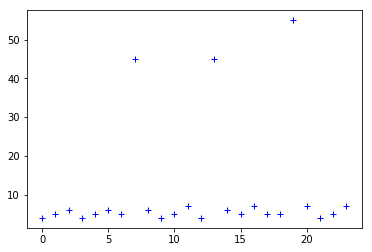

In [64]:
%matplotlib inline
g = np.array([4,5,6,4,5,6,5,45,6,4,5,7,4,45,6,5,7,5,5,55,7,4,5,7,])
plt.plot(g,'b+')

In [67]:
err = np.diff(g)
abser = np.abs(err[1::2])
quality = err[::2][:len(abser)]

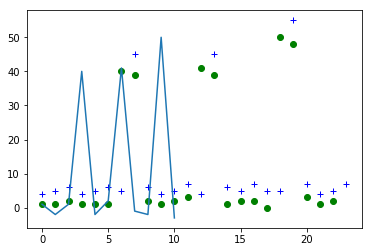

In [68]:
plt.plot(g,'b+')
plt.plot(np.abs(err),'go')
plt.plot(quality)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data


image = data.astronaut()
rows, cols = image.shape[0], image.shape[1]

src_cols = np.linspace(0, cols, 20)
src_rows = np.linspace(0, rows, 10)
src_rows, src_cols = np.meshgrid(src_rows, src_cols)
src = np.dstack([src_cols.flat, src_rows.flat])[0]

# add sinusoidal oscillation to row coordinates
dst_rows = src[:, 1] - np.sin(np.linspace(0, 3 * np.pi, src.shape[0])) * 50
dst_cols = src[:, 0]
dst_rows *= 1.5
dst_rows -= 1.5 * 50
dst = np.vstack([dst_cols, dst_rows]).T


tform = PiecewiseAffineTransform()
tform.estimate(src, dst)

out_rows = image.shape[0] - 1.5 * 50
out_cols = cols
out = warp(image, tform, output_shape=(out_rows, out_cols))

fig, ax = plt.subplots()
ax.imshow(out)
ax.plot(tform.inverse(src)[:, 0], tform.inverse(src)[:, 1], '.b')
ax.axis((0, out_cols, out_rows, 0))
plt.show()

In [188]:
plt.imshow(temperature_plot[:,:,2])

In [174]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure



# Find contours at a constant value of 0.8
contours = measure.find_contours(temperature_plot[:,:,2], 40)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(temperature_plot, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [176]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = temperature_plot[:,:,2]


#im = ndi.gaussian_filter(im, 4)

# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im)
edges2 = feature.canny(im, sigma=3)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('noisy image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title('Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title('Canny filter, $\sigma=3$', fontsize=20)

fig.tight_layout()

plt.show()

In [187]:
# Find contours at a constant value of 0.8
contours = measure.find_contours(edges2, 0.5)

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(temperature_plot, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    w,h = (np.max(contour,axis=0)-np.min(contour,axis=0))
    if w*h > 600:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [179]:
%qtconsole

In [ ]:
   # if the length the contours tuple returned by cv2.findContours
    # is '2' then we are using either OpenCV v2.4, v4-beta, or
    # v4-official
    if len(cnts) == 2:
        cnts = cnts[0]

    # if the length of the contours tuple is '3' then we are using
    # either OpenCV v3, v4-pre, or v4-alpha
    elif len(cnts) == 3:
        cnts = cnts[1]

In [192]:
# load the image and compute the ratio of the old height
# to the new height, clone it, and resize it
image = temperature_plot
ratio = image.shape[0] / 500.0
orig = image.copy() 
# convert the image to grayscale, blur it, and find edges
# in the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(gray, 75, 200)
 
# show the original image and the edge detected image
print("STEP 1: Edge Detection")
cv2.imshow("Image", image)
cv2.imshow("Edged", edged)
cv2.waitKey(0)
cv2.destroyAllWindows()
# find the contours in the edged image, keeping only the
# largest ones, and initialize the screen contour
cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# if the length the contours tuple returned by cv2.findContours
# is '2' then we are using either OpenCV v2.4, v4-beta, or
# v4-official
if len(cnts) == 2:
    cnts = cnts[0]

# if the length of the contours tuple is '3' then we are using
# either OpenCV v3, v4-pre, or v4-alpha
elif len(cnts) == 3:
    cnts = cnts[1]
cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
 
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
	# if our approximated contour has four points, then we
	# can assume that we have found our screen
	if len(approx) == 4:
		screenCnt = approx
		break
 
# show the contour (outline) of the piece of paper
print("STEP 2: Find contours of paper")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
cv2.imshow("Outline", image)
cv2.waitKey(0)
cv2.destroyAllWindows()

STEP 1: Edge Detection


error: /io/opencv/modules/highgui/src/window.cpp:583: error: (-2) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Carbon support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function cvShowImage


In [37]:
import numpy as np 
import matplotlib.pyplot as plt

x = np.arange(10)
y_ideal = np.array([4,4,4,0,0,0,2,2,2,0,0,0,1,1,1,0,0,0])
y_real = np.array([0,5,3,5,-1,1,1,3,1,3,-1,0,0,2,1,2,0,-1])

def func(params):
    xo,yo = params
    # rolling on the x
    y_real = np.roll(y_real,xo)
    # offset on the y
    y_real+= yo
    return np.sum((y_real-y_ideal)**2)/len(y_real)

def plotf(params):
    x0,y0 = params
    est,y_real2 = func(x0,y0)
    plt.plot(y_real2,'r')
    plt.plot(y_real,'k')
    plt.plot(y_ideal,'b')
    plt.title(est)

import scipy.optimize

In [9]:
%qtconsole

In [1]:
import numpy

# Generate artificial data = straight line with a=0 and b=1
# plus some noise.
xdata = numpy.array([0.0,1.0,2.0,3.0,4.0,5.0])
ydata = numpy.array([0.1,0.9,2.2,2.8,3.9,5.1])
# Initial guess.
x0    = numpy.array([0.0, 0.0, 0.0])

sigma = numpy.array([1.0,1.0,1.0,1.0,1.0,1.0])

def func(x, a, b, c):
    return a + b*x + c*x*x

import scipy.optimize as optimization

print(optimization.curve_fit(func, xdata, ydata, x0, sigma))

(array([ 0.1       ,  0.88142857,  0.02142857]), array([[ 0.02753741, -0.0197551 ,  0.0029932 ],
       [-0.0197551 ,  0.02436463, -0.0044898 ],
       [ 0.0029932 , -0.0044898 ,  0.00089796]]))
